In [1]:
import nibabel as nib
import pandas as pd
import numpy as np
from nilearn import signal, plotting, connectome
#from nilearn.datasets import fetch_atlas_surf_destrieux, fetch_parcellations # check step 6 for error
import matplotlib.pyplot as plt
import os

# Define the subject label and output directory (adjust as needed)
subject_label = 'sub-10'
session_label = 'ses-02'
fmriprep_out_dir = './fmriprep_out/'  # This should match the output directory used in the fmriprep command
output_dir = './rsFC_out/'  # This directory will contain all resting state functional connectivity outputs

# Construct the file paths for the Cifti file and confounds file
cifti_file = os.path.join(fmriprep_out_dir, f'{subject_label}_{session_label}_task-rest_space-fsLR_den-91k_bold.dtseries.nii')
confounds_file = os.path.join(fmriprep_out_dir, f'{subject_label}_{session_label}_task-rest_desc-confounds_timeseries.tsv')

In [2]:
# --- 1. Load the Cifti data ---
try:
    cifti_img = nib.load(cifti_file)
    cifti_data = cifti_img.get_fdata()
    print(f"Cifti data loaded successfully from: {cifti_file}")
    print(f"Cifti data shape: {cifti_data.shape} (Time points x Voxels/Vertices)")
except FileNotFoundError:
    print(f"Error: Cifti file not found at: {cifti_file}")
    exit()

Cifti data loaded successfully from: ./fmriprep_out/sub-10_ses-02_task-rest_space-fsLR_den-91k_bold.dtseries.nii
Cifti data shape: (132, 91282) (Time points x Voxels/Vertices)


In [3]:
# --- 2. Load the confounds ---
try:
    confounds_df = pd.read_csv(confounds_file, sep='\t')
    print(f"Confounds loaded successfully from: {confounds_file}")
except FileNotFoundError:
    print(f"Error: Confounds file not found at: {confounds_file}")
    exit()

Confounds loaded successfully from: ./fmriprep_out/sub-10_ses-02_task-rest_desc-confounds_timeseries.tsv


In [4]:
# --- 3. Prepare the confounds for denoising ---
# Select relevant confound regressors
confound_columns = [col for col in confounds_df.columns if
                    'trans' in col or 'rot' in col or 'derivative1' in col or 'power2' in col or 'global_signal' in col]
confounds = confounds_df[confound_columns].fillna(0).values
print(f"Selected confound columns: {confound_columns}")

Selected confound columns: ['global_signal', 'global_signal_derivative1', 'global_signal_derivative1_power2', 'global_signal_power2', 'csf_derivative1', 'csf_derivative1_power2', 'csf_power2', 'white_matter_derivative1', 'white_matter_power2', 'white_matter_derivative1_power2', 'trans_x', 'trans_x_derivative1', 'trans_x_power2', 'trans_x_derivative1_power2', 'trans_y', 'trans_y_derivative1', 'trans_y_power2', 'trans_y_derivative1_power2', 'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2', 'rot_x', 'rot_x_derivative1', 'rot_x_power2', 'rot_x_derivative1_power2', 'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2', 'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']


In [5]:
# --- 4. Denoise and Band-pass filter the Cifti data ---
# Remove the effect of confounds using linear regression and apply band-pass filtering.
low_pass = 0.1
high_pass = 0.01
tr = 3.0

filtered_data = signal.clean(
    cifti_data,          # The original data loaded from the Cifti file
    confounds=confounds, # The confounds DataFrame/array
    low_pass=low_pass,   # Low pass frequency
    high_pass=high_pass, # High pass frequency
    t_r=tr,              # Repetition time
    standardize='zscore_sample' # Standardization method
)

print("Denoising and band-pass filtering complete.")

Denoising and band-pass filtering complete.


/tmp/ipykernel_1363592/4187182751.py:7: DeprecationWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  filtered_data = signal.clean(


In [6]:
# --- 5. Define ROIs using a brain atlas (e.g., Gordon333 atlas)
# Download the Gordon fsLR32k atlas from https://balsa.wustl.edu/file/976Nr at first, and then load it
gordon_atlas = 'Gordon333.32k_fs_LR.dlabel.nii'  # fsLR32k atlas
atlas_img = nib.load(gordon_atlas)
atlas_data = atlas_img.get_fdata()  # get (1, grayordinates/Voxels/Vertices) array
atlas_data = np.squeeze(atlas_data)  # shape: (grayordinates/Voxels/Vertices,)

# Extract timeseries and labels
func_data = filtered_data
if func_data.shape[0] < func_data.shape[1]:
    func_data = func_data.T  # Now shape is (grayordinates/Voxels/Vertices, timepoints)

# Get unique parcels (excluding 0, which is "no label")
parcel_ids = np.unique(atlas_data)
parcel_ids = parcel_ids[parcel_ids != 0]

# Compute mean timeseries for each parcel
timeseries_list = []
labels_list = []

for parcel_id in parcel_ids:
    parcel_mask = atlas_data == parcel_id
    parcel_ts = func_data[parcel_mask, :].mean(axis=0)  # mean across vertices
    timeseries_list.append(parcel_ts)
    labels_list.append(parcel_id)

# Final matrix: parcels x timepoints
timeseries_array = np.vstack(timeseries_list)

# Load the Gordon 333 lookup table
# download the labels from https://github.com/brainspaces/gordon333/blob/master/gordon333NodeNames.txt at first, and then load it
gordon_lut = pd.read_csv('gordon333_lut.csv')    # fsLR32k altas list of ROIs (labels)

# Create a dictionary: {parcel_id: network_name}
parcel_to_network = dict(zip(gordon_lut['Parcel_ID'], gordon_lut['Network']))

# Map each extracted label to its network
network_names = [parcel_to_network[pid] for pid in labels_list]

# Save as DataFrame (timepoints x parcels)
timeseries_df = pd.DataFrame(timeseries_array.T, columns=labels_list)
timeseries_df.to_csv(output_dir+subject_label+'_'+session_label+'_parcel_timeseries.csv', index=False)

print("Done! Timeseries shape:", timeseries_df.shape)

# Initialize the ConnectivityMeasure (e.g., using correlation)
connectivity_measure = connectome.ConnectivityMeasure(kind='correlation')

print("Calculating connectivity matrix...")
connectivity_matrix = connectivity_measure.fit_transform([timeseries_array.T])[0]

print("Connectivity matrix calculated successfully.")
print("Connectivity matrix shape:", connectivity_matrix.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done! Timeseries shape: (132, 333)
Calculating connectivity matrix...
Connectivity matrix calculated successfully.
Connectivity matrix shape: (333, 333)


Visualizing the connectivity matrix...
Figure saved to: ./rsFC_out/sub-10_ses-02connectivity_matrix.png


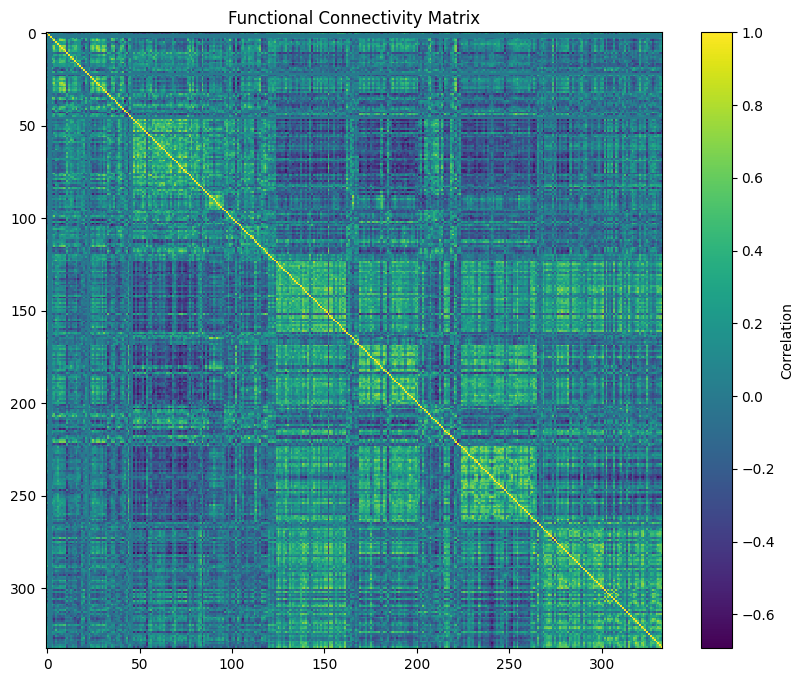

In [7]:
# --- 6. Visualize the connectivity matrix ---
if connectivity_matrix is not None:
    print("Visualizing the connectivity matrix...")
    plt.figure(figsize=(10, 8))
    plt.imshow(connectivity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Correlation')
    if 'ho_labels' in locals():
        plt.xticks(range(len(ho_labels)), ho_labels, rotation=90, fontsize=8)
        plt.yticks(range(len(ho_labels)), ho_labels, fontsize=8)
        plt.title('Functional Connectivity Matrix (Gordon333 Atlas)')
        plt.tight_layout()
    else:
        plt.title('Functional Connectivity Matrix')

    output_path = os.path.join(output_dir, subject_label+'_'+session_label+'connectivity_matrix.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {output_path}")
    plt.show()
else:
    print("Connectivity matrix not calculated, skipping visualization.")

In [8]:
# --- Further steps ---
print("\nNext steps for further analysis:")
print("- Group-level analysis: Perform statistical analysis across multiple subjects.")
print("- Network analysis: Investigate graph-theoretic properties of the connectivity matrix.")
print("- Seed-based correlation analysis: Examine connectivity patterns of specific brain regions.")
print("- Visualization of connectivity on the brain surface (requires surface-based tools).")


Next steps for further analysis:
- Group-level analysis: Perform statistical analysis across multiple subjects.
- Network analysis: Investigate graph-theoretic properties of the connectivity matrix.
- Seed-based correlation analysis: Examine connectivity patterns of specific brain regions.
- Visualization of connectivity on the brain surface (requires surface-based tools).
